# Neural Network from Scratch

This notebook contains an implementation of Multilayered Neural Network from Scratch. To implement this functionality I have implemented only numpy.

I have used keras to fetch the MNIST dataset in order to perform classification. Keras or tensorflow has not been used for any other purpose in this codebase.


### Model Configuration:

1. **Activation function:** Relu/Sigmoid for hidden layers and softmax for output layer.

2. **Dataset:** MNIST handwritten digits.

3. **Input Size:** [?, 784] where '?' is the number of samples and 784 is the number of feature in each sample. While displaying the image, it is reshaped to 28x28 size grayscale image.

4. **Output Size:** [?, 10] where '?' is the number of samples and '10' is the number of output classes (0-9).


### Equations for activation functions



\begin{equation}
ReLu(z) =
\begin{cases}
0 \text{ if } z < 0\\
z \text{otherwise}
\end{cases}
\end{equation}



\begin{equation}
Sigmoid(z) = \frac{1}{1 + e^{-z}}
\end{equation}



\begin{equation}
Softmax(z) = \frac{e^{z - max(z)}}{\sum_{i=0}^n e^{z - max(z)}}
\end{equation}


### Forward propagation

\begin{equation}
Output, a = Activation(W.x + b)
\end{equation}

Here,

- 'W' is the weight matrix of the current layer

- 'x' is the input matrix provided to the current layer

- 'b' is the bias for the current layer

If the previous layer 'A' contains 2 neurons and the current layer 'B' contains 3 neurons, then the weight matrix

\begin{equation}
W = \left\lbrack \matrix{W_{A_1B_1} W_{A_1B_2} W_{A_1B_3} \cr W_{A_2B_1} W_{A_2B_2} W_{A_2B_3}} \right\rbrack
\end{equation}

The input (assuming it contains 1 sample input

\begin{equation}
x = \left\lbrack \matrix{x_{A_1} x_{A_2}} \right\rbrack
\end{equation}

and the bias of the current layer

\begin{equation}
b = \left\lbrack \matrix{b_{B_1} b_{B_2} b_{B_3}} \right\rbrack
\end{equation}

Therefore the non-activated output

\begin{equation}
z = \left\lbrack \matrix{z_{B_1} z_{B_2} z_{B_3}} \right\rbrack
\end{equation}


### Error of output layer

The error of output layer is calculated by subtracting the value of each class of each sample from the value of each class of the training label (one hot encoded).

\begin{equation}
Error, E = A_{output} - Y_{true}
\end{equation}

If the final output contains 1 sample and 3 classes,

\begin{equation}
\left\lbrack \matrix{E_1 E_2 E_3} \right\rbrack = \left\lbrack \matrix{A_1 A_2 A_3} \right\rbrack - \left\lbrack \matrix{Y_1 Y_2 Y_3} \right\rbrack
\end{equation}


### Gradient of the weights of the output layer

The gradient is calculated by calculating the dot product between the transpose matrix of the input provided to the output layer and the error obtained from the output layer. It is then scaled by the total number of samples available in the input matrix.


\begin{equation}
Gradient, G = \frac{1}{n} * (x_{output}^T . E_{output}) = \frac{1}{n} * (\left\lbrack \matrix{x_1 \cr x_2} \right\rbrack . \left\lbrack \matrix{E_1 E_2 E_3} \right\rbrack)
\end{equation}

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [3]:
class NeuralNetwork:
    def __init__(self, layers, activation='relu', verbose=False):
        self.verbose = verbose
        self.layers = layers
        self.activation = activation
        self.weights = []
        self.biases = []
        for i in range(1, len(layers)):
            self.weights.append(np.random.randn(layers[i-1], layers[i]))
            self.biases.append(np.zeros((1, layers[i])))

    def println(self, content):
        if self.verbose:
            print(str(content))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def relu(self, z):
        return np.maximum(0, z)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    

    def feedforward(self, x):
        a = x
        for i in range(len(self.layers) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.println(f"Layer: {i}, Output: {z.shape}")
            if self.activation == 'sigmoid':
                a = self.sigmoid(z)
            elif self.activation == 'relu':
                a = self.relu(z)
        return self.softmax(z)

    def backward(self, x, y, learning_rate=0.1):
        gradients_w = [np.zeros(w.shape) for w in self.weights]
        gradients_b = [np.zeros(b.shape) for b in self.biases]
        a = x
        activations = [x]
        zs = []
        for i in range(len(self.layers) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            zs.append(z)
            if i == len(self.layers) - 2:
                self.println(f"Adding softmax activation to output of layer {i+1}")
                a = self.softmax(z)
            elif self.activation == 'sigmoid':
                self.println(f"Adding sigmoid activation to output of layer {i+1}")
                a = self.sigmoid(z)
            elif self.activation == 'relu':
                self.println(f"Adding relu activation to output of layer {i+1}")
                a = self.relu(z)
            activations.append(a)
        self.println(f"Total activations (First value is the input): {len(activations)}, Total non-activated outputs: {len(zs)}")

        delta = activations[-1] - y
        self.println(f"Error (activations[-1] - y): {delta.shape}")

        self.println(f"Gradient calculation for weights[-1] by activations[-2].T (dot) delta: {activations[-2].T.shape} (dot) {delta.shape}")
        gradients_w[-1] = (1/y.shape[0]) * np.dot(activations[-2].T, delta)
        gradients_b[-1] = (1/y.shape[0]) * np.sum(delta, axis=0, keepdims=True)


        for i in range(2, len(self.layers)):
            z = zs[-i]
            if self.activation == 'sigmoid':
                sp = self.sigmoid(z) * (1 - self.sigmoid(z))
            elif self.activation == 'relu':
                sp = np.where(z > 0, 1.0, 0)
            self.println(f"Calculating delta by [delta (dot) self.weights[{-i+1}].T]* [zs[{-i}]]: [{delta.shape} (dot) {self.weights[-i+1].T.shape}]*{sp.shape}")
            delta = np.dot(delta, self.weights[-i+1].T) * sp
            self.println(f"Gradient calculation for weights[-{i}] by activations[{-i-1}].T (dot) delta: {activations[-i-1].T.shape} (dot) {delta.shape}")
            gradients_w[-i] = (1/y.shape[0]) * np.dot(activations[-i-1].T, delta)
            gradients_b[-i] = (1/y.shape[0]) * np.sum(delta, axis=0, keepdims=True)
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * gradients_w[i]
            self.biases[i] -= learning_rate * gradients_b[i]

    def train(self, x_train, y_train, epochs=100, batch_size=32, learning_rate=0.1):
        for epoch in range(epochs):
            idx = np.random.permutation(len(x_train))
            x_train, y_train = x_train[idx], y_train[idx]
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                self.backward(x_batch, y_batch, learning_rate)

    def predict(self, x):
        return np.argmax(self.feedforward(x), axis=1)

Total classes: 10
(60000, 784) (60000, 10) (10000, 784) (10000, 10)


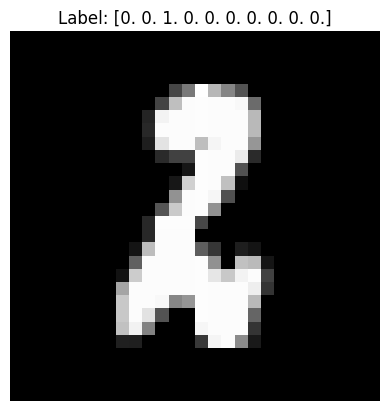

In [26]:
# Load the MNIST dataset
def one_hot_encoded(label, total_classes):
    encoded = np.zeros((label.size, total_classes))
    encoded[np.arange(label.size), label] = 1.0
    return encoded

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0

total_classes = np.maximum(np.unique(y_train).size, np.unique(y_test).size)
print(f"Total classes: {total_classes}")

y_train = one_hot_encoded(y_train, total_classes)
y_test = one_hot_encoded(y_test, total_classes)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

i = np.random.randint(0, y_train.shape[0])
plt.figure()
plt.title(f"Label: {y_train[i]}")
plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [27]:
# Define the network architecture and training parameters
layers = [784, 128, 64, 10]
nn = NeuralNetwork(layers, activation='relu', verbose=False)
epochs = 20
batch_size = 32
learning_rate = 0.001

In [28]:
print("Total layers: " + str(len(nn.weights)))
for i in range(len(nn.weights)):
    print("Layer: " + str(i+1))
    print("    Weights: " + str(nn.weights[i].shape))
    print("    Biases: " + str(nn.biases[i].shape))

Total layers: 3
Layer: 1
    Weights: (784, 128)
    Biases: (1, 128)
Layer: 2
    Weights: (128, 64)
    Biases: (1, 64)
Layer: 3
    Weights: (64, 10)
    Biases: (1, 10)


In [29]:
y_pred = nn.feedforward(X_train)
print(y_pred.shape)
print(y_pred[0])
print(np.sum(y_pred[0]))

(60000, 10)
[9.30328093e-172 0.00000000e+000 2.57571087e-074 0.00000000e+000
 1.00000000e+000 3.34808067e-076 4.63646829e-225 1.00190128e-052
 2.57921727e-226 0.00000000e+000]
1.0


In [30]:
# Train the network
nn.train(X_train, y_train, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

In [31]:
# Evaluate the performance on the test set
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred == np.argmax(y_test, axis=1))
print('Test accuracy:', accuracy)

Test accuracy: 0.8296


In [32]:
y_pred = nn.predict(X_train)
accuracy = np.mean(y_pred == np.argmax(y_train, axis=1))
print('Train accuracy:', accuracy)

Train accuracy: 0.8353833333333334


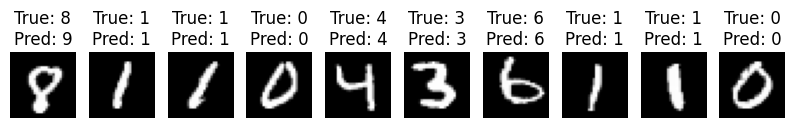

In [33]:
# Plot some example predictions
n_examples = 10
indices = np.random.choice(len(X_test), n_examples)
images = X_test[indices]
labels = y_test[indices]
predictions = nn.predict(images)
plt.figure(figsize=(10, 10))
for i in range(n_examples):
    plt.subplot(1, n_examples, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('True: {}\nPred: {}'.format(np.argmax(labels[i]), predictions[i]))
plt.show()

## Visualization

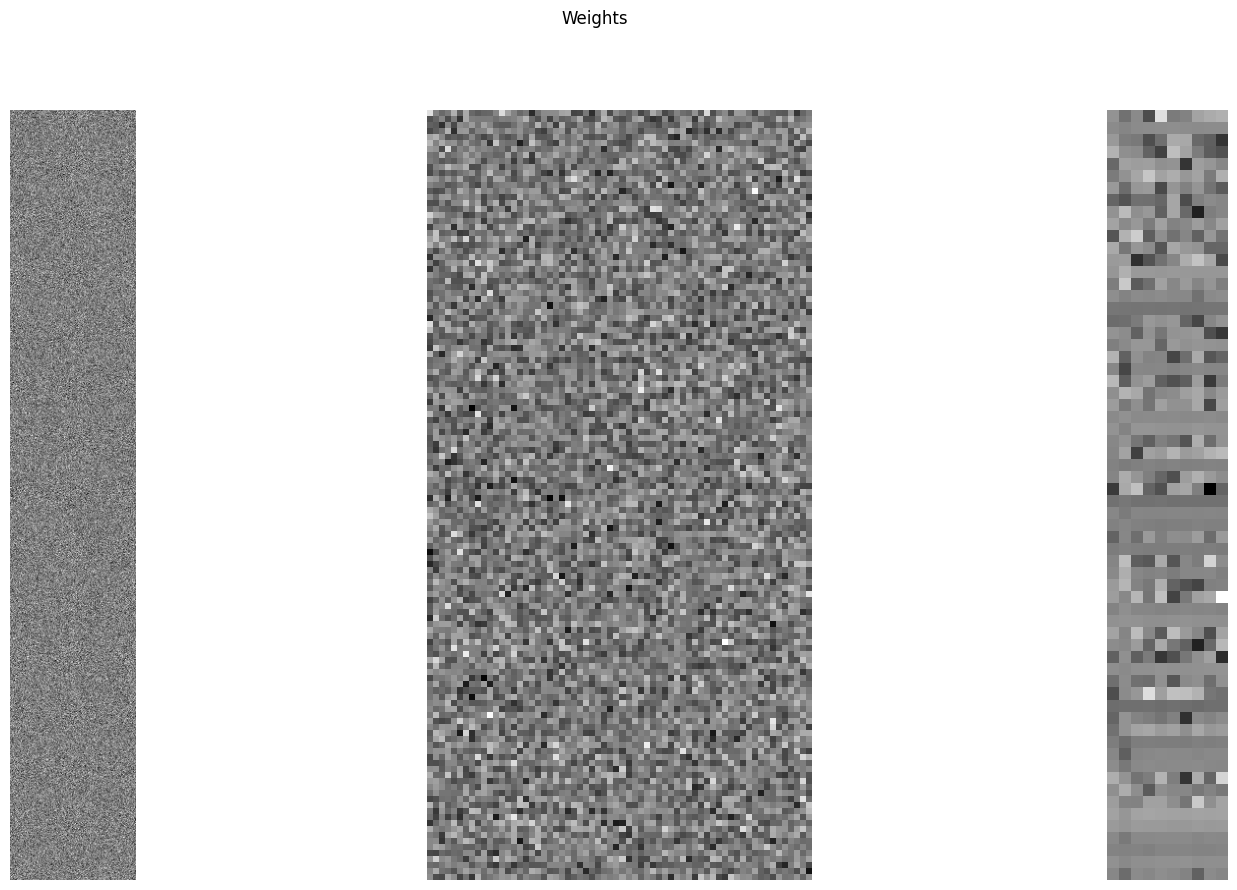

In [35]:
plt.figure(figsize=(20, 10))
plt.suptitle("Weights")
for i in range(len(nn.weights)):
    plt.subplot(1, len(nn.weights), i+1)
    plt.imshow(nn.weights[i]/np.max(nn.weights[i]), cmap='gray')
    plt.axis('off')
plt.show()

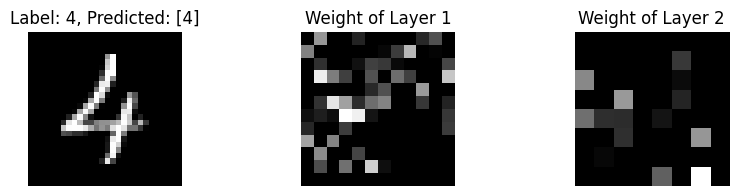

In [41]:
index = np.random.randint(0, len(X_test))

sample_x, sample_y = X_test[index], y_test[index]

outputs = []
a = sample_x.reshape(1, sample_x.size)
for i in range(len(nn.weights)-1):
    z = np.dot(a, nn.weights[i]) + nn.biases[i]
    if nn.activation == 'relu':
        a = nn.relu(z)
    else:
        a = nn.sigmoid(z)
    outputs.append(a)


plt.figure(figsize=(10, 2))

plt.subplot(1, len(nn.weights), 1)
plt.imshow(sample_x.reshape(1, sample_x.size)[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {np.argmax(sample_y)}, Predicted: {nn.predict(sample_x.reshape(1, sample_x.size))}")
plt.axis('off')

plt.subplot(1, len(nn.weights), 2)
plt.imshow((np.array(list(outputs[0][0]) + ([0]*16)).reshape(12, 12)/np.max(outputs[0])), cmap='gray')
plt.title("Weight of Layer 1")
plt.axis('off')

plt.subplot(1, len(nn.weights), 3)
plt.imshow((outputs[1][0].reshape(8, 8)/np.max(outputs[1])), cmap='gray')
plt.title("Weight of Layer 2")
plt.axis('off')

plt.show()